Mounted at /content/drive


NameError: name 'pd' is not defined

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
from google.colab import drive
drive.mount('/content/drive')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Heiti TC', 'PingFang HK', 'Microsoft YaHei', 'SimSun']  # 优先级从左到右
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

df = pd.read_csv('drive/MyDrive/init.csv')

df.set_index('timestamp', inplace=True)





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def calculate_atr(df, period=14):
    # 计算三种价格范围
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())

    # 真实范围取最大值
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)

    # 使用 Wilder 的平滑方法计算 ATR
    atr = pd.Series(index=df.index, dtype=float)
    atr.iloc[period-1] = true_range[:period].mean()  # 第一个ATR值使用简单平均

    # 使用 Wilder 的平滑方法计算后续值
    for i in range(period, len(df)):
        atr.iloc[i] = (atr.iloc[i-1] * (period-1) + true_range.iloc[i]) / period

    return atr

# 计算 ATR
df['ATR'] = calculate_atr(df)
df['ATR_Pct'] = (df['ATR'] / df['close']) * 100

## 简易支撑压力 ##


In [4]:
# 支撑位：最近N根K线的最低价（动态窗口）
def dynamic_support(data, window=30):
    return data['low'].rolling(window).min()

# 阻力位：最近N根K线的最高价（动态窗口）
def dynamic_resistance(data, window=30):
    return data['high'].rolling(window).max()

# 加入波动率调整
df['support'] = dynamic_support(df) * (1 - 0.1*df['ATR_Pct'])
df['resistance'] = dynamic_resistance(df) * (1 + 0.1*df['ATR_Pct'])

## 动量压缩比 ##

In [5]:
def calculate_momentum_compression_ratio(dataframe, short_window, long_window):
    dataframe['Short_Term_Momentum'] = dataframe['close'].diff(periods=short_window)
    dataframe['Long_Term_Momentum'] = dataframe['close'].diff(periods=long_window)
    dataframe['Momentum_Compression_Ratio'] = dataframe['Short_Term_Momentum'] / dataframe['Long_Term_Momentum']
    return dataframe

# 设置参数，例如短期5分钟，长期15分钟
df = calculate_momentum_compression_ratio(df, short_window=5, long_window=15)


## 弹性 ##

In [6]:
def calculate_elasticity_coefficient(dataframe, window):
    roll_max = dataframe['high'].rolling(window=window, min_periods=1).max()
    roll_min = dataframe['low'].rolling(window=window, min_periods=1).min()
    dataframe['Elasticity'] = (dataframe['close'] - roll_min) / (roll_max - roll_min)
    return dataframe

# 应用函数，例如使用14分钟作为窗口
df = calculate_elasticity_coefficient(df, window=14)


## 压力 ##

In [7]:
def calculate_pressure_accumulation(dataframe):
    # 根据收盘价是否高于开盘价来决定多空力量
    dataframe['Pressure'] = np.where(dataframe['close'] > dataframe['open'],
                                     dataframe['volume'], -dataframe['volume'])
    # 累积多空力量
    dataframe['Cumulative_Pressure'] = dataframe['Pressure'].cumsum()

    return dataframe

# 应用函数到实际数据
df = calculate_pressure_accumulation(df)

#


## Hurst ##


In [8]:
from hurst import compute_Hc

def calculate_fractal_dimension(dataframe, window):
    H, c, data = compute_Hc(dataframe['close'].values, kind='price', simplified=True)
    D = 2 - H
    return H, D

# 计算示例数据集的Hurst指数和分形维度
H, D = calculate_fractal_dimension(df, window=60)
print("Hurst指数:", H)
print("分形维度:", D)

ModuleNotFoundError: No module named 'hurst'

## RSI ##


In [9]:


def calculate_rsi_wilder(df, period=14):
    # 计算价格变化
    delta = df['close'].diff()

    # 分别获取上涨和下跌
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    # Wilder's EMA 使用 alpha = 1/period
    # 首次计算简单平均值
    avg_gain = gain[:period].mean()
    avg_loss = loss[:period].mean()

    # 准备存放 RSI 的序列
    rsi_series = pd.Series(index=df.index, dtype=float)

    # 第一个 RSI 值
    rsi_series.iloc[period] = 100 - (100 / (1 + (avg_gain / avg_loss)))

    # 使用 Wilder 的平滑方法计算后续值
    for i in range(period + 1, len(df)):
        avg_gain = ((avg_gain * (period - 1)) + gain.iloc[i]) / period
        avg_loss = ((avg_loss * (period - 1)) + loss.iloc[i]) / period
        if avg_loss != 0:
            rs = avg_gain / avg_loss
            rsi_series.iloc[i] = 100 - (100 / (1 + rs))
        else:
            rsi_series.iloc[i] = 100

    return rsi_series

# 计算 Wilder's RSI

df['RSI_Wilder'] = calculate_rsi_wilder(df)



In [ ]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions', 'ATR',
       'ATR_Pct', 'support', 'resistance', 'Short_Term_Momentum',
       'Long_Term_Momentum', 'Momentum_Compression_Ratio', 'Elasticity',
       'Pressure', 'Cumulative_Pressure', 'RSI_Wilder'],
      dtype='object')

## ML ##

In [12]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 检查并处理缺失值
if df.isnull().any().any():
    # 可以选择填充缺失值或删除含有缺失值的行
    df.fillna(method='ffill', inplace=True)  # 向前填充
    # 或者 data.dropna(inplace=True)  # 删除含有缺失值的行

# 对数变换（对适合的数值列）
for col in ['volume', 'transactions', 'ATR', 'ATR_Pct']:
    # 仅对正数进行对数变换
    df[col] = np.log1p(df[col].clip(lower=0))

# 标准化
scaler = StandardScaler()
features = ['open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions', 'ATR', 'ATR_Pct', 'Short_Term_Momentum', 'Long_Term_Momentum', 'Momentum_Compression_Ratio', 'Elasticity', 'Pressure', 'Cumulative_Pressure', 'RSI_Wilder']
df[features] = scaler.fit_transform(df[features])

<ipython-input-12-ce93e9a1c514>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # 向前填充


In [19]:
# 按照时间戳索引升序排序
df.sort_index(ascending=True, inplace=True)
df.tail()


,open,high,low,close,volume,vwap,transactions,ATR,ATR_Pct,support,resistance,Short_Term_Momentum,Long_Term_Momentum,Momentum_Compression_Ratio,Elasticity,Pressure,Cumulative_Pressure,RSI_Wilder
timestamp,,,,,,,,,,,,,,,,,,
2025-02-10 23:55:00,3.286425,3.282889,3.282628,3.278433,-1.106688,3.282666,-1.106688,1.812916,1.461696,2897.821368,2934.435240,-0.085594,-0.443978,-0.029569,-0.524282,-0.751860,1.662057,0.526342
2025-02-10 23:56:00,3.274725,3.286092,3.278589,3.276762,0.786216,3.280553,0.786216,1.770759,1.416197,2898.432971,2934.261065,-0.659701,-0.188326,0.200000,-0.614813,1.139325,1.672677,0.460872
2025-02-10 23:57:00,3.274168,3.273557,3.275943,3.276762,0.786216,3.274518,0.786216,1.606110,1.240976,2899.120456,2933.591223,-0.332460,-0.121923,0.145791,-0.614813,1.139325,1.683298,0.460872
2025-02-10 23:58:00,3.263025,3.259489,3.262432,3.258238,-1.106688,3.260868,-1.106688,1.623917,1.261174,2899.043580,2933.668361,-1.629941,-1.177732,0.053322,-1.610655,-0.751860,1.676218,-0.247275
2025-02-10 23:59:00,3.255643,3.263807,3.259507,3.263113,0.786216,3.262215,0.786216,1.552858,1.186390,2899.328127,2933.382847,-1.296959,-1.207613,0.031743,-1.073446,1.139325,1.686838,-0.065847


In [23]:
df.dropna(inplace=True)
print(df.isnull().sum())

open                          0
high                          0
low                           0
close                         0
volume                        0
vwap                          0
transactions                  0
ATR                           0
ATR_Pct                       0
support                       0
resistance                    0
Short_Term_Momentum           0
Long_Term_Momentum            0
Momentum_Compression_Ratio    0
Elasticity                    0
Pressure                      0
Cumulative_Pressure           0
RSI_Wilder                    0
dtype: int64


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 假设 data 是已经加载的DataFrame
# 提取特征和目标
features = ['open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions', 'ATR', 'ATR_Pct', 'Short_Term_Momentum', 'Long_Term_Momentum', 'Momentum_Compression_Ratio', 'Elasticity', 'Pressure', 'Cumulative_Pressure', 'RSI_Wilder']
X = df[features]
y = df['support']

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 创建线性回归模型
model = LinearRegression()

# 训练模型
model.fit(X_train, y_train)

# 评估模型
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -scores.mean())

# 测试集上的性能
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


Cross-validated MSE: 1.220892596724842
Test MSE: 1.2736153505343808


### RF ###

In [26]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 577 (delta 116), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (577/577), 188.95 KiB | 2.52 MiB/s, done.
Resolving deltas: 100% (290/290), done.
Using Python 3.11.11 environment at /usr
Resolved 2 packages in 143ms
Prepared 2 packages in 36ms
Installed 2 packages in 0.91ms
 + nvidia-ml-py==12.570.86
 + pynvml==12.0.0
Installing RAPIDS remaining 24.12.* libraries
Using Python 3.11.11 environment at /usr
Resolved 154 packages in 1.64s
Prepared 30 packages in 25.27s
Uninstalled 3 packages in 41ms
Installed 30 packages in 23ms
 + cucim-cu12==24.12.0
 + cugraph-cu12==24.12.0
 + cuml-cu12==24.12.0
 + cuproj-cu12==24.12.0
 + cuspatial-cu12==24.12.0
 + cuvs-cu12==24.12.0
 + cuxfilter-cu12==24.12.0
 - dask==2024.10.0
 + dask==2024.11.2
 + dask-cuda==24.12.0
 + dask-cudf-cu12==24.12.0
 

In [38]:
len(df)

97113

In [40]:
import cudf
import cuml
from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.model_selection import train_test_split
from cuml.metrics import mean_squared_error

# 假设 data 是已经加载并预处理的 DataFrame
# 将 pandas DataFrame 转换为 cuDF DataFrame
gdf = cudf.DataFrame.from_pandas(df)

# 划分数据集
X = df[features]
y = df['support']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建随机森林模型
rf = cuRF(n_estimators=100, random_state=42)

# 训练模型
rf.fit(X_train, y_train)

# 预测测试集
y_pred = rf.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Test MSE: 1.3618917250648384


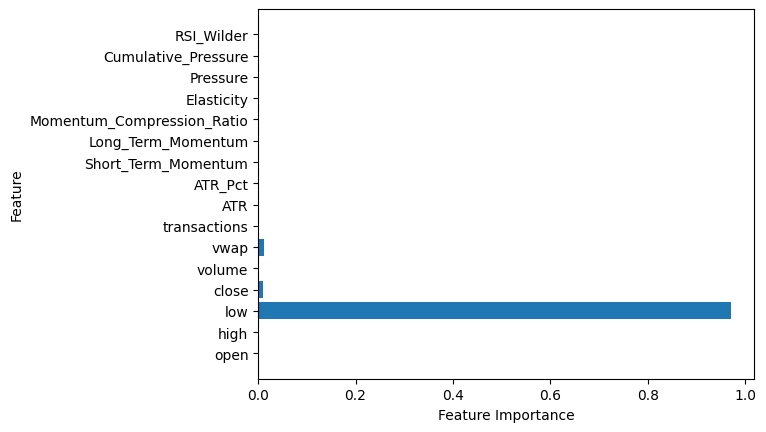

Test MSE: 0.7037336880261493


In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 假设X和y已经是预处理并准备好的数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建随机森林模型
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rf.fit(X_train, y_train)

# 获取特征重要性
importances = rf.feature_importances_

# 显示特征重要性
feature_names = X.columns
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

# 预测并计算MSE
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


## DS ##

pandas.core.frame.DataFrame

In [45]:
import pandas as pd
from scipy import stats

def dynamic_levels(data, window=30, confidence=0.95):
    """
    返回带置信区间的动态支撑阻力位
    """
    # 计算基础水平
    support_base = data['low'].rolling(window).min()
    resist_base = data['high'].rolling(window).max()

    # 计算置信区间的辅助函数
    def calc_interval(row):
        if pd.isna(row['base']) or pd.isna(row['std']):
            return pd.NA, pd.NA
        ci = stats.t.interval(confidence, window-1, loc=row['base'], scale=row['std'])
        return ci[0], ci[1]

    # 合并基础和标准差，逐行应用 calc_interval 函数
    support_data = pd.DataFrame({
        'base': support_base,
        'std': data['low'].rolling(window).std()
    })
    resist_data = pd.DataFrame({
        'base': resist_base,
        'std': data['high'].rolling(window).std()
    })

    support_ci = support_data.apply(calc_interval, axis=1)
    resist_ci = resist_data.apply(calc_interval, axis=1)

    # 处理结果，分解为上下限
    support_ci_low = support_ci.apply(lambda x: x[0])
    support_ci_high = support_ci.apply(lambda x: x[1])

    resist_ci_low = resist_ci.apply(lambda x: x[0])
    resist_ci_high = resist_ci.apply(lambda x: x[1])

    return {
        'support': (support_base, (support_ci_low, support_ci_high)),
        'resistance': (resist_base, (resist_ci_low, resist_ci_high))
    }

# 示例使用
levels = dynamic_levels(df)
current_support = levels['support'][0].iloc[-1]
current_resistance = levels['resistance'][0].iloc[-1]
support_ci_low, support_ci_high = levels['support'][1][0].iloc[-1], levels['support'][1][1].iloc[-1]


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

class BreakProbabilityModel:
    def __init__(self):
        self.model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
        self.features = ['distance', 'volatility', 'volume_ratio', 'momentum']

    def calculate_features(self, data):
        """
        计算突破相关特征
        """
        # 当前价格到支撑/阻力的距离（标准化）
        data['distance'] = (data['close'] - current_support) / (current_resistance - current_support)

        # 波动率冲击
        data['vol_shock'] = data['ATR_Pct'] / data['ATR_Pct'].rolling(50).mean()

        # 量能比率
        data['volume_ratio'] = data['volume'] / data['volume'].rolling(30).mean()

        # 动量强度
        data['momentum'] = data['close'].pct_change(5)
        return data

    def fit(self, X, y):
        self.model.fit(X[self.features], y)

    def explain_break(self, X):
        # 计算特征重要性
        result = permutation_importance(self.model, X[self.features], X['break'], n_repeats=10)
        return {f: i for f, i in zip(self.features, result.importances_mean)}

    def monte_carlo_simulation(self, current_state, n_sims=1000):
        """
        蒙特卡洛模拟突破概率
        """
        paths = []
        for _ in range(n_sims):
            # 基于当前波动率和动量生成路径
            path = current_state['close'] * np.exp(np.cumsum(
                np.random.normal(current_state['momentum'], current_state['volatility'], 10)
            ))
            paths.append(path)
        # 计算突破次数
        break_count = sum([max(path) > current_resistance or min(path) < current_support for path in paths])
        return break_count / n_sims

# 初始化模型
bpm = BreakProbabilityModel()
data = bpm.calculate_features(df)

,open,high,low,close,volume,vwap,transactions,ATR,ATR_Pct,support,...,Long_Term_Momentum,Momentum_Compression_Ratio,Elasticity,Pressure,Cumulative_Pressure,RSI_Wilder,distance,vol_shock,volume_ratio,momentum
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-30 00:00:00,1.274033,1.271792,1.276426,1.272308,0.786216,1.274053,0.786216,11.129211,25.253096,2661.375645,...,-48.011797,0.076941,-1.610655,-1.130097,1.676218,-4.123095,-14.637178,NaN,NaN,NaN
2024-10-30 00:01:00,1.277376,1.277085,1.281301,1.280386,-1.106688,1.279091,-1.106688,10.771163,23.666072,2669.078035,...,-47.918833,0.076590,-1.598687,0.761088,1.683298,-4.088466,-14.575206,NaN,NaN,NaN
2024-10-30 00:02:00,1.283504,1.280010,1.281301,1.282614,0.786216,1.281343,0.786216,10.411588,22.145827,2676.313913,...,-47.865711,0.076589,-1.595385,-1.130097,1.672677,-4.078233,-14.558110,NaN,NaN,NaN
2024-10-30 00:03:00,1.284062,1.280567,1.286593,1.282475,-1.106688,1.283478,-1.106688,10.042224,20.656573,2683.269752,...,-47.706343,0.075882,-1.595592,-0.751860,1.665597,-4.078255,-14.559179,NaN,NaN,NaN
2024-10-30 00:04:00,1.282529,1.280567,1.285340,1.281222,0.786216,1.282781,0.786216,9.679583,19.263002,2689.662048,...,-47.613379,0.076484,-1.597449,-1.130097,1.654976,-4.078475,-14.568795,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 23:55:00,3.286425,3.282889,3.282628,3.278433,-1.106688,3.282666,-1.106688,1.812916,1.461696,2897.821368,...,-0.443978,-0.029569,-0.524282,-0.751860,1.662057,0.526342,0.753182,1.988652,-4.371989,-0.000637
2025-02-10 23:56:00,3.274725,3.286092,3.278589,3.276762,0.786216,3.280553,0.786216,1.770759,1.416197,2898.432971,...,-0.188326,0.200000,-0.614813,1.139325,1.672677,0.460872,0.740360,1.889718,3.105960,-0.004864
2025-02-10 23:57:00,3.274168,3.273557,3.275943,3.276762,0.786216,3.274518,0.786216,1.606110,1.240976,2899.120456,...,-0.121923,0.145791,-0.614813,1.139325,1.683298,0.460872,0.740360,1.633509,3.105960,-0.002459


In [56]:
from sklearn.ensemble import GradientBoostingRegressor

class NextLevelPredictor:
    def __init__(self):
        self.support_model = GradientBoostingRegressor()
        self.resist_model = GradientBoostingRegressor()
        self.features = ['fractal_dim', 'vol_cluster', 'pressure', 'hurst']

    def fit(self, X, y_support, y_resist):
        self.support_model.fit(X[self.features], y_support)
        self.resist_model.fit(X[self.features], y_resist)

    def predict_next_level(self, X, break_direction):
        if break_direction == 'up':
            return self.resist_model.predict(X[self.features])[0] * 1.02  # 2%过滤
        elif break_direction == 'down':
            return self.support_model.predict(X[self.features])[0] * 0.98
        else:
            return None

# 使用示例
nlp = NextLevelPredictor()
next_support = nlp.predict_next_level(current_features, 'down')

NameError: name 'current_features' is not defined